<a href="https://colab.research.google.com/github/sydstewart/Orders/blob/main/Impsim_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Simulation Report 
 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Percent of small jobs= 51.9 % of size range 1 to 6  days work
Percent of medium jobs= 48.1 % of size range 7 to 22  days work
Percent of big jobs= 0.0 % of size range 23 to 100  days work
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running simulation...over 1 years
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Histograms of project end to end times in days - average duration shown in red dashes
    Kitters  Configers  End to End Average  No. of Projects per year  \
0       1.0        1.0               136.0                      27.0   
1       1.0        1.0               136.0                      27.0   
2  

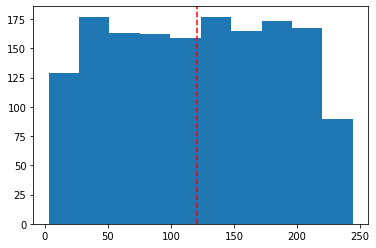

In [15]:
"""Companion code to https://realpython.com/simulation-with-simpy/
'Simulating Real-World Processes With SimPy'
Python version: 3.7.3
SimPy version: 3.0.11
"""
!pip install simpy
import simpy
import random
import statistics
import numpy as np
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas

wait_times = []
kitwork_times = []
kitconfig_times = []
kitwait_times = []

small_job_count = []
med_job_count = []
big_job_count = []

# Job size in work days
small_job_days_low = 1
small_job_days_high = 6

med_job_days_low = 7
med_job_days_high = 22

big_job_days_low = 23
big_job_days_high = 100

# Percentage of Jobs ( 1 to 100% big jobs = 100 - percent_med_jobs) max percentages
percent_small_jobs = 60
percent_med_jobs = 98

# Value of job sizes
value_small_jobs = 3000
value_med_jobs = 14000
value_big_jobs = 50000

# average annual staff salary + overheads
annual_average_salary = 70000
percentage_of_time_on_Projects = 100

class Implement(object):
    def __init__(self, env, num_kitters, num_custs, num_configers):
        self.env = env
        self.kitter = simpy.Resource(env, num_kitters)
        self.custs = simpy.Resource(env, num_custs)
        self.configers = simpy.Resource(env, num_configers)

        # self.usher = simpy.Resource(env, num_ushers)

     # time it takes to kit
    def kitwork(self, project):
        yield self.env.timeout(random.randint(1, 2))

     # time waiting on customer 
    def kitwait(self, project):
        yield self.env.timeout(random.randint(1, 3))

     # time to configure
    def config_wait(self, project):
      # project size set randomly to a distribution of projects small, medium, large
       
       samplerand = random.randint(1, 100)
      
       #small projects
       if samplerand >=1 and samplerand <= percent_small_jobs:
           timeout = self.env.timeout(random.randint(small_job_days_low, small_job_days_high))
           yield timeout
           small_job_count.append(timeout) 

       #medium projects
       elif samplerand >=percent_small_jobs + 1 and samplerand <= percent_med_jobs:
          medtimeout = self.env.timeout(random.randint(med_job_days_low, med_job_days_high)) 
          yield medtimeout
          med_job_count.append(medtimeout)

       #big projects
       elif samplerand >=percent_med_jobs + 1 and samplerand <= 100:
         big_timeout =  self.env.timeout(random.randint(big_job_days_low, big_job_days_high))      
         yield  big_timeout
         big_job_count.append(big_timeout)

def go_to_implement(env, project, implementation):
    # Project arrives at the implementation
    arrival_time = env.now
    kit_arrival_time = env.now
      
    with implementation.kitter.request() as request:
        yield request
        yield env.process(implementation.kitwork(project))
    # print('after kit', env.now - kit_arrival_time)
    kitwork_times.append(env.now - kit_arrival_time)

    cust_arrival_time = env.now
    with implementation.custs.request() as request:
        yield request
        yield env.process(implementation.kitwait(project))

    kitwait_times.append(env.now - cust_arrival_time)

    config_arrival_time = env.now

    with implementation.configers.request() as request:
        yield request
        yield env.process(implementation.config_wait(project))
    kitconfig_times.append(env.now - config_arrival_time)

    wait_times.append(env.now - arrival_time)

def run_implementation(env, num_kitters, num_custs, num_configers):
    implementation = Implement( env, num_kitters, num_custs , num_configers)
   #starts with loading 1 project
    for project in range(1):
        env.process(go_to_implement(env, project, implementation))

    while True:
        yield env.timeout(0.20)  # Wait a bit before generating a new project

        project += 1
        env.process(go_to_implement(env, project, implementation))


def get_average_wait_time(wait_times):
    average_hours = statistics.mean(wait_times)
    average_days = average_hours
    # Pretty print the results
    # minutes, frac_minutes = divmod(average_wait, 1)
    # seconds = frac_minutes * 60
    return average_days #round(minutes), round(seconds)



def main():
    # Setup
   
    #-----------------------------------------------------
    #-----------------------------------------------------
    random.seed(13)
    num_years_sim = 1                 
    num_custs = 1             
    max_configers = 7
    max_kitters = 4
    #--------------------------------------------------
    #-----------------------------------------------------

    data =[]
    mydataframe = []
    # Run the simulation
    loop = 1 # to loop through staff types - kitters, configers
    for num_configers in range( 1,max_configers):
            for num_kitters in range( 1,max_kitters):
                  env = simpy.Environment()
                  env.process(run_implementation(env, num_kitters, num_custs, num_configers))
                  env.run(until=254 *  num_years_sim )
                  
                  #========================================================

                  # View the results

                  average_days = statistics.mean(wait_times)
                  average_config_days = statistics.mean(kitconfig_times)
                  average_cust_wait_days = statistics.mean(kitwait_times)
                  average_kit_days = statistics.mean(kitwork_times)

                  if loop ==1:
                        print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
                        print(                       'Simulation Report ')     
                        print(' ' )

                       
                        # job sizes
                        print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++') 
                        print('Percent of small jobs=', round(len(small_job_count)*100/len(wait_times),1),'%', 'of size range',small_job_days_low,'to', small_job_days_high,' days work')
                        print('Percent of medium jobs=', round(len(med_job_count)*100/len(wait_times),1),'%', 'of size range',med_job_days_low,'to', med_job_days_high,' days work')
                        print('Percent of big jobs=', round(len(big_job_count)*100/len(wait_times),1),'%', 'of size range',big_job_days_low,'to', big_job_days_high,' days work')
                        print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
                        print(' ') 
                        
                        
                        print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++') 
                        print(
                            "Running simulation...over",num_years_sim,'years')
                        #     f"\nThe average project 'end to end' time is {round(average_days)} working days to complete the projects",
                        # )
                        # print('Number of projects  processed=', len(wait_times))

                        # print('Average no. of projects per year =', round(len(wait_times)/num_years_sim ))
                        # # print("==================wait_times =============================")
                        # # print(wait_times)
                        # # print("==================kitwork_times =============================")
                        # # print(kitwork_times)
                        # print(' ') 
                        print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
                      

                        
                        # Import pandas library
                        import pandas as pd
                        pd.set_option("max_rows", None)
                        pd.set_option("max_columns", None)

                        
                        # Create the pandas DataFrame
                        data = {'Kitters': [num_kitters * percentage_of_time_on_Projects/100] ,
                                'Configers': [num_configers * percentage_of_time_on_Projects/100],
                                'End to End Average': [round(average_days)],
                                'No. of Projects per year': [round(len(wait_times)/num_years_sim)],
                                'No. of config days average': [round(average_config_days)],
                                'No. of cust_wait days average': [round(average_cust_wait_days)] ,
                                'No. of kit days average': [round(average_kit_days)],
                                'Small jobs': [round(len(small_job_count))],   
                                'Med jobs': [round(len(med_job_count))] ,  
                                'Big jobs': [round(len(big_job_count))] ,
                                'Total jobs':[round(len(small_job_count)) + round(len(med_job_count)) + round(len(big_job_count))],
                                'Total Earnings':[round(len(small_job_count))*value_small_jobs + round(len(med_job_count))*value_med_jobs + round(len(big_job_count))*value_big_jobs ],
                                'Costs': [((num_kitters +  num_configers))*annual_average_salary],
                                'Margin' :[(round(len(small_job_count))*value_small_jobs + round(len(med_job_count))*value_med_jobs + round(len(big_job_count))*value_big_jobs) - ((num_kitters +  num_configers))*annual_average_salary]
                                }

                        df_marks = pd.DataFrame(data)
                        mydataframe = pd.DataFrame(data)
                        # print(df_marks)
                
                        loop = loop + 1
                  
                  if loop > 1:
                        new_row = pd.Series({'Kitters':num_kitters  * percentage_of_time_on_Projects/100, 'Configers':num_configers  * percentage_of_time_on_Projects/100, 'End to End Average':round(average_days), 
                                             'No. of Projects per year':round(len(wait_times)/num_years_sim),  
                                             'No. of config days average': round(average_config_days),  
                                             'No. of cust_wait days average': round(average_cust_wait_days) ,
                                             'No. of kit days average': round(average_kit_days),
                                             'Small jobs': round(len(small_job_count)),
                                             'Med jobs': round(len(med_job_count)) ,  
                                             'Big jobs': round(len(big_job_count)) ,
                                             'Total jobs': round(len(small_job_count)) + round(len(med_job_count)) + round(len(big_job_count)),
                                             'Total Earnings':round(len(small_job_count))*value_small_jobs + round(len(med_job_count))*value_med_jobs + round(len(big_job_count)) *value_big_jobs ,   
                                             'Costs': ((num_kitters +  num_configers) *annual_average_salary) ,
                                              'Margin' : (round(len(small_job_count))*value_small_jobs + round(len(med_job_count))*value_med_jobs + round(len(big_job_count))*value_big_jobs) - ((num_kitters +  num_configers))*annual_average_salary
                                              })                                              
                      
                        mydataframe = mydataframe.append(new_row, ignore_index=True)

    

    #====================Plot histogram of wait times
    print('Histograms of project end to end times in days - average duration shown in red dashes')
    n, bins, patches = plt.hist(wait_times)
    plt.axvline(x=average_days, color='r', linestyle = 'dashed')
    # n, bins, patches = plt.hist(small_job_count)
    # plt.axvline(x=small_job_count, color='r', linestyle = 'dashed')

    print(mydataframe)

    print('      ')
    
    print('Minimum End to end time=', min(wait_times))
    print('Maximum End to end time=', max(wait_times))        
     
    
if __name__ == "__main__":
    main()